# Investments Project (Spring 2024)

This project focuses on constructing and evaluating optimal portfolios using beta, idiosyncratic volatility, and momentum signals. The goal is to apply finance theory to portfolio management, accounting for transaction costs and volatility variations. We aim to build optimal portfolios, analyze their performance with risk factors from Ken French’s website, and compare strategies for creating industry-neutral portfolios.

**Group members** : Youssef Belghmi, Othmane Idrissi Oudghiri, Mhamed Sefrioui, Hamza Morchid

In [31]:
# Necessary imports :

from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools.tools import add_constant
from IPython.display import display, HTML
from scipy.optimize import minimize
from datetime import datetime
from scipy import stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

import datetime
import wrds

import warnings
warnings.filterwarnings('ignore')

# 1. The Data
Let's download monthly CRSP stock returns from January 1 (1964) through December 31 (2023) for all common stocks traded on the NYSE and AMEX, with value-weighted CRSP market return and 1-month T-bill returns as a risk-free rate.

In [3]:
# Connection to WRDS
db = wrds.Connection(wrds_username='*******')

# Query for monthly common stock returns (NYSE & AMEX)
query_stocks = """
SELECT a.date, a.permno, a.ret, a.vol, a.shrout, a.prc
FROM crsp.msf AS a
JOIN crsp.msenames AS b ON a.permno = b.permno
WHERE a.date >= '1964-01-01' AND a.date <= '2023-12-31'
AND b.namedt <= a.date AND a.date <= b.nameendt
AND b.exchcd IN (1, 2)
AND b.shrcd IN (10, 11)
"""

# Uploading stock data
stocks_data = db.raw_sql(query_stocks)

# Calculation of market capitalization
stocks_data['mkt_cap'] = stocks_data['prc'].abs() * stocks_data['shrout']

# Ensure date is in datetime format
stocks_data['date'] = pd.to_datetime(stocks_data['date'])

# Query for value-weighted market returns
query_market = """
SELECT date, vwretd as mkt_ret
FROM crsp.msi
WHERE date >= '1964-01-01' AND date <= '2023-12-31'
"""

# Market data download
market_data = db.raw_sql(query_market)

# Ensure date is in datetime format
market_data['date'] = pd.to_datetime(market_data['date'])

# Query for 1-month T-bill returns as a risk-free rate
query_rf = """
SELECT mcaldt as date, tmytm as rf
FROM crsp.tfz_mth_rf
WHERE kytreasnox = '2000001'
AND mcaldt >= '1964-01-01' AND mcaldt <= '2023-12-31'
"""

# Risk-free rate data download
rf_data = db.raw_sql(query_rf)

# Conversion from annual rate to monthly rate in decimal format
rf_data['rf'] = (rf_data['rf'] / 12) / 100

# Ensure date is in datetime format
rf_data['date'] = pd.to_datetime(rf_data['date'])

# Save rf_rate data to a CSV file
rf_data.to_csv('risk_free_data.csv', index=False)

# Merging data step-by-step
res = stocks_data.merge(market_data, on='date', how='inner')
res = res.merge(rf_data, on='date', how='inner')

# Calculation of excess returns
res['excess_ret'] = res['ret'] - res['rf']
res['excess_mkt_ret'] = res['mkt_ret'] - res['rf']

# Save merged data to a CSV file
res.to_csv('Dataframe.csv', index=False)

# Closing the connection to WRDS
db.close()

# Display the first rows of the resulting DataFrame
res.head()

Loading library list...
Done


,date,permno,ret,vol,shrout,prc,mkt_cap,mkt_ret,rf,excess_ret,excess_mkt_ret
0,1992-06-30,10028,-0.206897,184.0,5632.0,-1.43750,8096.000,-0.019258,0.002928,-0.209825,-0.022186
1,1992-05-29,10028,-0.205479,75.0,5548.0,-1.81250,10055.750,0.006407,0.003030,-0.208509,0.003377
2,1992-04-30,10028,-0.170455,278.0,5548.0,-2.28125,12656.375,0.013414,0.002920,-0.173375,0.010494
3,1992-03-31,10028,0.419355,1051.0,5548.0,2.75000,15257.000,-0.023699,0.003343,0.416012,-0.027042
4,1998-05-29,10028,0.047619,184.0,4151.0,2.75000,11415.250,-0.025746,0.003806,0.043813,-0.029552


The resulting DataFrame corresponds to a set of monthly financial data for common stocks traded on the NYSE and AMEX exchanges as well as the risk-free rate, over a period from January 1, 1964 to December 31, 2023. We find the following information there :
- **date** : The date of the month for which the data is recorded (YYYY-MM-DD).
- **permno** : Permanent unique identifier assigned to each action in the CRSP database.
- **ret** : Monthly stock return expressed as a decimal (can be interpreted as a percentage by multiplying by 100).
- **vol** : Volume of shares traded during the month.
- **shrout** : Number of shares outstanding for the stock.
- **prc** : Closing stock price for the month.
- **mkt_cap** : Market capitalization, calculated as the price per share multiplied by the number of shares outstanding.
- **mkt_ret** : A value-weighted monthly market return, this return represents the overall market performance for the month.
- **rf_rate** : Taux sans risque mensuel des bons du Trésor à 1 mois (can be interpreted as a percentage by multiplying by 100).

# 2. Betting against Beta strategy (BaB)

Let us calculate the time-varying market beta (β) for each stock by running 5-year monthly rolling regressions of stock-specific excess returns on the market excess return, with, at least, 36 months of observations for each stock.

In [4]:
res['date'] = pd.to_datetime(res['date'])
res = res.sort_values(['permno', 'date'])

# Remove nans
beta_data = res.dropna(subset=['mkt_cap','excess_ret','excess_mkt_ret']).copy()

# Remove stocks with less than 60 observations
beta_data['N'] = beta_data.groupby(['permno'])['date'].transform('count')
beta_data = beta_data[beta_data['N']>60].copy()

# Estimate Rolling Betas
cov_nm = beta_data.set_index('date').groupby('permno')[['excess_ret','excess_mkt_ret']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'excess_mkt_ret':'beta'})

# Merge With data 
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
beta_data = pd.merge(beta_data, beta_n, on=['date','permno'], how='left')

# Remove outliers
beta_data['beta'] = beta_data['beta'].clip(beta_data['beta'].quantile(0.05), beta_data['beta'].quantile(0.95))

# Remove nan values
beta_data = beta_data.dropna()

# Displaying the obtained results
beta_data.head()

,date,permno,ret,vol,shrout,prc,mkt_cap,mkt_ret,rf,excess_ret,excess_mkt_ret,N,beta
37,2013-01-31,10001,0.062701,4241.0,8157.0,9.87,80509.59,0.054142,0.000051,0.062650,0.054091,92,0.483312
38,2013-02-28,10001,0.011651,2600.0,8157.0,9.94,81080.58,0.008282,0.000040,0.011611,0.008242,92,0.502670
39,2013-03-28,10001,0.030684,3237.0,8157.0,10.20,83201.40,0.035295,0.000034,0.030650,0.035261,92,0.502510
45,2013-09-30,10001,0.004412,3366.0,10372.0,10.20,105794.40,0.037497,0.000017,0.004395,0.037480,92,0.497200
49,2014-01-31,10001,0.147572,17688.0,10452.0,9.17,95844.84,-0.030020,0.000042,0.147530,-0.030062,92,0.445111


Let's sort all stocks into deciles based on their beta and then calculate monthly returns for 10-decile portfolios that equally weight all stocks in each decile.

In [5]:
# Drop rows with missing 'beta' values and make a copy of the dataframe
beta_data = beta_data.dropna(subset=['beta']).copy()

# Create decile groups based on 'beta' for each date
beta_data['beta_Q'] = beta_data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Calculate market weights within quintiles
beta_data['vw_Q'] = beta_data['mkt_cap'] / beta_data.groupby(['date', 'beta_Q'])['mkt_cap'].transform('sum')

# Calculate value-weighted portfolio returns
beta_data['beta_ret_vw'] = beta_data['vw_Q'] * beta_data['ret']
ret_beta_vw = beta_data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_beta_mean = ret_beta_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# Rename 'beta_ret_vw' to 'ret' for consistency
ret_beta_vw = ret_beta_vw.rename(columns={"beta_ret_vw": "ret"})

# Calculate equal-weighted portfolio returns
ret_beta_ew = beta_data.groupby(['date', 'beta_Q'])['ret'].mean().reset_index()
ew_ret_beta_mean = ret_beta_ew.groupby('beta_Q')['ret'].mean()

Now, let's plot, for equal-weighted and value-weighted decile portfolios, the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots.

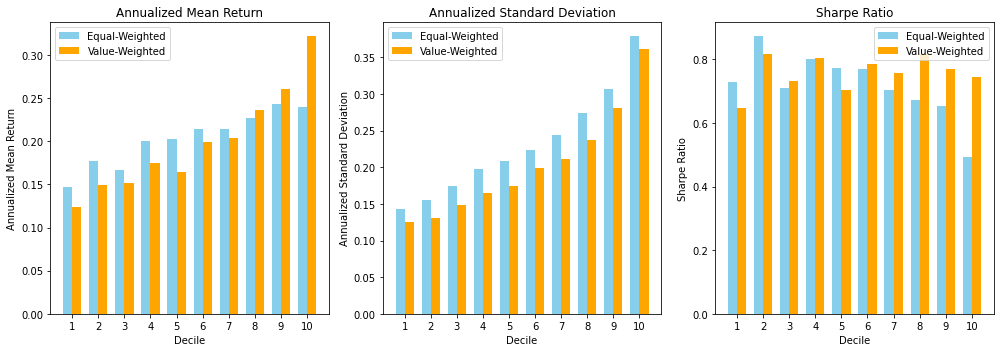

In [6]:
# Function to compute annualized returns, standard deviation, and Sharpe ratio
def compute_metrics_beta(beta_data, rf):
    beta_data = beta_data.merge(rf, on='date')
    beta_data['excess_return'] = beta_data['ret'] - beta_data['rf']
    annualized_mean_return = beta_data.groupby('beta_Q')['ret'].mean() * 12
    annualized_mean_excess_return = beta_data.groupby('beta_Q')['excess_return'].mean() * 12
    annualized_std = beta_data.groupby('beta_Q')['ret'].std() * (12 ** 0.5)
    sharpe_ratio = annualized_mean_excess_return / annualized_std
    return annualized_mean_return, annualized_std, sharpe_ratio

# Computing metrics for both VW and EW portfolios
annualized_mean_return_vw, annualized_std_vw, sharpe_ratio_vw = compute_metrics_beta(ret_beta_vw, rf_data)
annualized_mean_return_ew, annualized_std_ew, sharpe_ratio_ew = compute_metrics_beta(ret_beta_ew, rf_data)

# Plot the metrics side by side
deciles = np.arange(1, 11)
bar_width = 0.35

plt.figure(figsize=(14, 5))

# Plot the annualized mean returns
plt.subplot(1, 3, 1)
plt.bar(deciles - bar_width/2, annualized_mean_return_ew ,bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, annualized_mean_return_vw, bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Mean Return')
plt.xlabel('Decile')
plt.ylabel('Annualized Mean Return')
plt.xticks(deciles)
plt.legend()

# Plot the annualized standard deviation
plt.subplot(1, 3, 2)
plt.bar(deciles - bar_width/2, annualized_std_ew, bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, annualized_std_vw, bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Standard Deviation')
plt.xlabel('Decile')
plt.ylabel('Annualized Standard Deviation')
plt.xticks(deciles)
plt.legend()

# Plot the Sharpe ratios
plt.subplot(1, 3, 3)
plt.bar(deciles - bar_width/2, sharpe_ratio_ew, bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, sharpe_ratio_vw, bar_width, label='Value-Weighted', color='orange')
plt.title('Sharpe Ratio')
plt.xlabel('Decile')
plt.ylabel('Sharpe Ratio')
plt.xticks(deciles)
plt.legend()

plt.tight_layout()
plt.show()

Summarize our findings : 
- **Annualized Mean Return** : The value-weighted portfolios tend to have higher annualized mean returns compared to equal-weighted portfolios, especially in the higher beta deciles. However, both equal-weighted and value-weighted portfolios generally show increasing returns as we move from the lowest beta deciles to the highest beta deciles. So, the increase in mean returns with higher beta deciles is consistent with CAPM.

- **Annualized Standard Deviation** : Equal-weighted portfolios exhibit slightly higher volatility compared to value-weighted portfolios. From the graph, we can conclude that the annualized standard deviation increases across the deciles, indicating higher risk for higher beta deciles, which aligns with the CAPM prediction. 

- **Sharpe Ratio** : Sharpe ratios for value-weighted portfolios are a little bit higher than those for equal-weighted portfolios. For both portfolios, we obtain a slightly decreasing Sharpe ratio, suggesting that the additional returns obtained for high beta stocks do not always compensate for the increased risk, which may contradict CAPM predictions.

Now, let's construct the Betting-Against-Beta (BAB) factor as in Frazzini & Pedersen (2014). The goal is to construct a BAB factor by ranking stocks each month according to their beta, constructing high-beta and low-beta portfolios, and calculating the return of the BAB factor by taking the difference between the returns of these portfolios.

In [7]:
# Weights
beta_data['z'] = beta_data.groupby('date')['beta'].transform(lambda x: x.rank())
beta_data['z_'] = beta_data['z']-beta_data.groupby('date')['z'].transform('mean')
beta_data['k'] = np.abs(beta_data['z_'])
beta_data['k'] = 2/beta_data.groupby('date')['k'].transform('sum')
beta_data['w_H'] = beta_data['k'] * beta_data['z_'] * (beta_data['z_']>0) 
beta_data['w_L'] = -beta_data['k'] * beta_data['z_'] * (beta_data['z_']<0) 

# Weighted returns and beta
beta_data['beta_H'] = beta_data['w_H'] * beta_data['beta']
beta_data['beta_L'] = beta_data['w_L'] * beta_data['beta']
beta_data['R_H'] = beta_data['w_H'] * beta_data['ret']
beta_data['R_L'] = beta_data['w_L'] * beta_data['ret']
beta_data['R_H_e'] = beta_data['w_H'] * beta_data['excess_ret']
beta_data['R_L_e'] = beta_data['w_L'] * beta_data['excess_ret']

# Group by 'date' and sum the calculated values
BAB = beta_data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()

# Levered and unlevered returns
BAB['BAB'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']

We can analyze the performance of the BAB factor using the CAPM model to determine the alpha of the factor, representing the excess return adjusted for market risk, in order to assess whether the BAB factor generates returns beyond those explained by the market.

In [8]:
# Merge the BAB DataFrame with the market excess return data to include excess_mkt_ret in the analysis
tmp = pd.merge(BAB, beta_data[['date', 'excess_mkt_ret']].drop_duplicates(), on=['date'], how='left')

# Add a constant column for the OLS regression
tmp['const'] = 1

# Remove rows with missing values
tmp = tmp.dropna()

# Perform an OLS regression of the BAB returns on the constant and the market excess returns
OLS_Reg = sm.OLS(tmp['BAB'], tmp[['const', 'excess_mkt_ret']]).fit()

# Calculate various metrics from the regression results:
Alpha_bab = OLS_Reg.params[0] * 12
idio_vol = (tmp['BAB'] - OLS_Reg.predict()).std() * np.sqrt(12)
market_rp = tmp['excess_mkt_ret'].mean() * 12
market_vol = tmp['excess_mkt_ret'].std() * np.sqrt(12)
beta_bab = OLS_Reg.params[1]

# Print the calculated metrics
print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ', tmp['BAB'].mean() / tmp['BAB'].std() * np.sqrt(12))
print('Idiosyncratic volatility: ', idio_vol)
print('Beta BAB: ', beta_bab)
print('Market Risk Premium: ', market_rp)
print('Market Volatility: ', market_vol)

Annualized Alpha of BAB factor:  0.06885185903997942 2.7631110004195563
Sharpe Ratio of BAB factor:  0.7742697664782453
Idiosyncratic volatility:  0.1115753755177644
Beta BAB:  0.49883576533317275
Market Risk Premium:  0.07872392238908127
Market Volatility:  0.1683371576179868


Overall, the BAB factor appears to offer potential benefits in terms of returns relative to its risk profile.

# 3. Momentum Strategy (Mom)

Let's determine whether the momentum strategy is effective and whether its results are in line with or contradict the predictions of the CAPM model. This includes examining the returns, volatility and risk-adjusted performance of portfolios formed using a momentum strategy, as well as assessing the statistical significance of the returns obtained.

In [9]:
# Copy the original data to a new DataFrame for momentum analysis
momentum_data = res.copy()

# Sort the data by 'permno' and 'date', then reset the index
momentum_data.sort_values(['permno', 'date']).reset_index(drop=True)

# Calculate the 12-month cumulative log returns (excluding the current month)
momentum_data['LN_Cret12'] = momentum_data.groupby('permno').apply(lambda x: np.log(x.ret + 1).rolling(11, closed='left').sum()).values

# Assign momentum quintiles based on the cumulative log returns
momentum_data['Momentum_Q'] = momentum_data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop'))

# Calculate the value weights for each momentum quintile within each date
momentum_data['vw_Q_M'] = momentum_data['mkt_cap'] / momentum_data.groupby(['date', 'Momentum_Q'])['mkt_cap'].transform('sum')

# Calculate value-weighted returns for each momentum quintile
momentum_data['Momentum_ret_vw'] = momentum_data['vw_Q_M'] * momentum_data['ret']
ret_momentum_vw = momentum_data.groupby(['date', 'Momentum_Q'])['Momentum_ret_vw'].sum().reset_index()
vw_ret_momentum_mean = ret_momentum_vw.groupby('Momentum_Q')['Momentum_ret_vw'].mean()

# Rename the 'Momentum_ret_vw' column to 'ret' for value-weighted returns
ret_momentum_vw = ret_momentum_vw.rename(columns={"Momentum_ret_vw": "ret"})

# Calculate equal-weighted returns for each momentum quintile
ret_momentum_ew = momentum_data.groupby(['date', 'Momentum_Q'])['ret'].mean().reset_index()
ew_ret_momentum_mean = ret_momentum_ew.groupby('Momentum_Q')['ret'].mean()

Here are the plots of the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots.

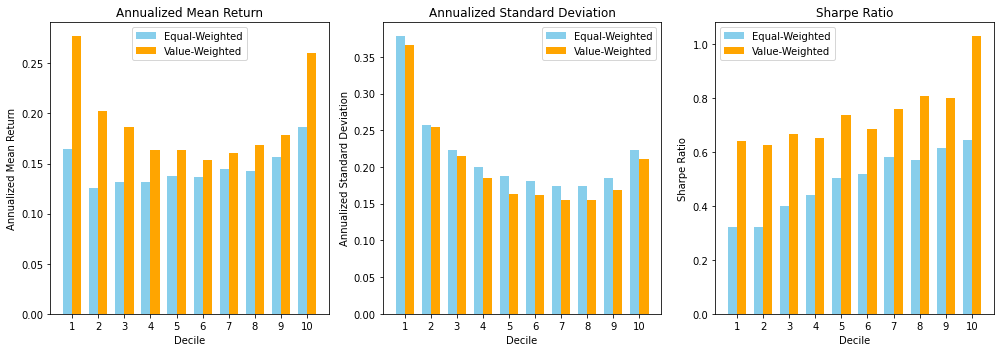

In [10]:
# Function to compute annualized returns, standard deviation, and Sharpe ratio
def compute_metrics_momentum(momentum_data, rf):
    momentum_data = momentum_data.merge(rf, on='date')
    momentum_data['excess_return'] = momentum_data['ret'] - momentum_data['rf']
    annualized_mean_return = momentum_data.groupby('Momentum_Q')['ret'].mean() * 12
    annualized_mean_excess_return = momentum_data.groupby('Momentum_Q')['excess_return'].mean() * 12
    annualized_std = momentum_data.groupby('Momentum_Q')['ret'].std() * (12 ** 0.5)
    sharpe_ratio = annualized_mean_excess_return / annualized_std
    return annualized_mean_return, annualized_std, sharpe_ratio

# Computing metrics for both VW and EW portfolios
annualized_mean_return_vw_momentum, annualized_std_vw_momentum, sharpe_ratio_vw_momentum = compute_metrics_momentum(ret_momentum_vw, rf_data)
annualized_mean_return_ew_momentum, annualized_std_ew_momentum, sharpe_ratio_ew_momentum = compute_metrics_momentum(ret_momentum_ew, rf_data)

# Plot the metrics side by side
deciles = np.arange(1, 11)
bar_width = 0.35

plt.figure(figsize=(14, 5))

# Plot the annualized mean returns
plt.subplot(1, 3, 1)
plt.bar(deciles - bar_width/2, annualized_mean_return_ew_momentum, bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, annualized_mean_return_vw_momentum, bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Mean Return')
plt.xlabel('Decile')
plt.ylabel('Annualized Mean Return')
plt.xticks(deciles)
plt.legend()

# Plot the annualized standard deviation
plt.subplot(1, 3, 2)
plt.bar(deciles - bar_width/2, annualized_std_ew_momentum, bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, annualized_std_vw_momentum, bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Standard Deviation')
plt.xlabel('Decile')
plt.ylabel('Annualized Standard Deviation')
plt.xticks(deciles)
plt.legend()

# Plot the Sharpe ratios
plt.subplot(1, 3, 3)
plt.bar(deciles - bar_width/2, sharpe_ratio_ew_momentum, bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, sharpe_ratio_vw_momentum, bar_width, label='Value-Weighted', color='orange')
plt.title('Sharpe Ratio')
plt.xlabel('Decile')
plt.ylabel('Sharpe Ratio')
plt.xticks(deciles)
plt.legend()

plt.tight_layout()
plt.show()

Summarize our findings : 
- **Annualized Mean Return** : We observe that average annualized returns generally increase across deciles, particularly for value-weighted portfolios. The highest deciles (9 and 10) exhibit significantly higher returns compared to the lowest deciles. This pattern aligns with the momentum effect, suggesting that stocks which have performed well in the past tend to continue performing well.

- **Annualized Standard Deviation** : The annualized standard deviation shows a tendency to decrease as one moves from lower to higher deciles, which could indicate that stocks with higher momentum are less volatile.

- **Sharpe Ratio** : Sharpe ratios generally increase with deciles, indicating that portfolios with higher momentum provide better risk-adjusted returns. The value-weighted portfolios show significantly higher Sharpe ratios in the top deciles, highlighting their enhanced performance adjusted for risk.

We further analyze the momentum strategy by constructing a long-short portfolio, taking long positions in the top three deciles and short positions in the bottom three deciles. We calculate and compare some metrics for both the long and short legs, as well as the overall strategy.

In [11]:
# Calculate monthly returns for long and short legs (equal-weighted)
long_deciles = [7, 8, 9]
short_deciles = [0, 1, 2]

# Calculate returns for long and short legs (equal-weighted)
long_momentum_equal_returns = ret_momentum_ew[ret_momentum_ew['Momentum_Q'].isin(long_deciles)].groupby('date')['ret'].mean()
short_momentum_equal_returns = ret_momentum_ew[ret_momentum_ew['Momentum_Q'].isin(short_deciles)].groupby('date')['ret'].mean()
momentum_equal_returns = long_momentum_equal_returns - short_momentum_equal_returns

# Calculate returns for long and short legs (value-weighted)
long_momentum_value_returns = ret_momentum_vw[ret_momentum_vw['Momentum_Q'].isin(long_deciles)].groupby('date')['ret'].mean()
short_momentum_value_returns = ret_momentum_vw[ret_momentum_vw['Momentum_Q'].isin(short_deciles)].groupby('date')['ret'].mean()
momentum_value_returns = long_momentum_value_returns - short_momentum_value_returns

# Function to calculate financial metrics
def compute_financial_metrics_momentum(momentum_data, rf):
    momentum_data = momentum_data.reset_index()
    momentum_data = momentum_data.merge(rf, on='date')
    momentum_data['excess_return'] = momentum_data['ret'] - momentum_data['rf']
    annualized_mean_return = momentum_data['ret'].mean() * 12
    annualized_mean_excess_return = momentum_data['excess_return'].mean() * 12
    annualized_std = momentum_data['ret'].std() * np.sqrt(12)
    sharpe_ratio = annualized_mean_excess_return / annualized_std
    return annualized_mean_return, annualized_std, sharpe_ratio

# Calculate metrics for equal-weighted returns
mean_long_equal_momentum, std_long_equal_momentum, sharpe_long_equal_momentum = compute_financial_metrics_momentum(long_momentum_equal_returns, rf_data)
mean_short_equal_momentum, std_short_equal_momentum, sharpe_short_equal_momentum = compute_financial_metrics_momentum(short_momentum_equal_returns, rf_data)
mean_momentum_equal, std_momentum_equal, sharpe_momentum_equal = compute_financial_metrics_momentum(momentum_equal_returns, rf_data)

# Calculate metrics for value-weighted returns
mean_long_value_momentum, std_long_value_momentum, sharpe_long_value_momentum = compute_financial_metrics_momentum(long_momentum_value_returns, rf_data)
mean_short_value_momentum, std_short_value_momentum, sharpe_short_value_momentum = compute_financial_metrics_momentum(short_momentum_value_returns, rf_data)
mean_momentum_value, std_momentum_value, sharpe_momentum_value = compute_financial_metrics_momentum(momentum_value_returns, rf_data)

# Test if the average return of the strategy is significantly different from zero
t_stat_equal_momentum, p_value_equal_momentum = stats.ttest_1samp(momentum_equal_returns, 0)
t_stat_value_momentum, p_value_value_momentum = stats.ttest_1samp(momentum_value_returns, 0)

# Display results side by side
momentum_equal_weighted_portfolios = f"""
<div style="display: inline-block; width: 45%; vertical-align: top;">
    <h3>Equal-Weighted Portfolios:</h3>
    <p>Mean Long Return: {mean_long_equal_momentum:.4f}</p>
    <p>Std Dev Long Return: {std_long_equal_momentum:.4f}</p>
    <p>Sharpe Ratio Long: {sharpe_long_equal_momentum:.4f}</p>
    <p>Mean Short Return: {mean_short_equal_momentum:.4f}</p>
    <p>Std Dev Short Return: {std_short_equal_momentum:.4f}</p>
    <p>Sharpe Ratio Short: {sharpe_short_equal_momentum:.4f}</p>
    <p>Mean Momentum Return: {mean_momentum_equal:.4f}</p>
    <p>Std Dev Momentum Return: {std_momentum_equal:.4f}</p>
    <p>Sharpe Ratio Momentum: {sharpe_momentum_equal:.4f}</p>
    <p>t-Statistic Momentum: {t_stat_equal_momentum:.4f}</p>
    <p>p-Value Momentum: {p_value_equal_momentum:.4f}</p>
</div>
"""

momentum_value_weighted_portfolios = f"""
<div style="display: inline-block; width: 45%; vertical-align: top;">
    <h3>Value-Weighted Portfolios:</h3>
    <p>Mean Long Return: {mean_long_value_momentum:.4f}</p>
    <p>Std Dev Long Return: {std_long_value_momentum:.4f}</p>
    <p>Sharpe Ratio Long: {sharpe_long_value_momentum:.4f}</p>
    <p>Mean Short Return: {mean_short_value_momentum:.4f}</p>
    <p>Std Dev Short Return: {std_short_value_momentum:.4f}</p>
    <p>Sharpe Ratio Short: {sharpe_short_value_momentum:.4f}</p>
    <p>Mean Momentum Return: {mean_momentum_value:.4f}</p>
    <p>Std Dev Momentum Return: {std_momentum_value:.4f}</p>
    <p>Sharpe Ratio Momentum: {sharpe_momentum_value:.4f}</p>
    <p>t-Statistic Momentum: {t_stat_value_momentum:.4f}</p>
    <p>p-Value Momentum: {p_value_value_momentum:.4f}</p>
</div>
"""

display(HTML(momentum_equal_weighted_portfolios + momentum_value_weighted_portfolios))

Display what we got in a graph will help us better understand the results.

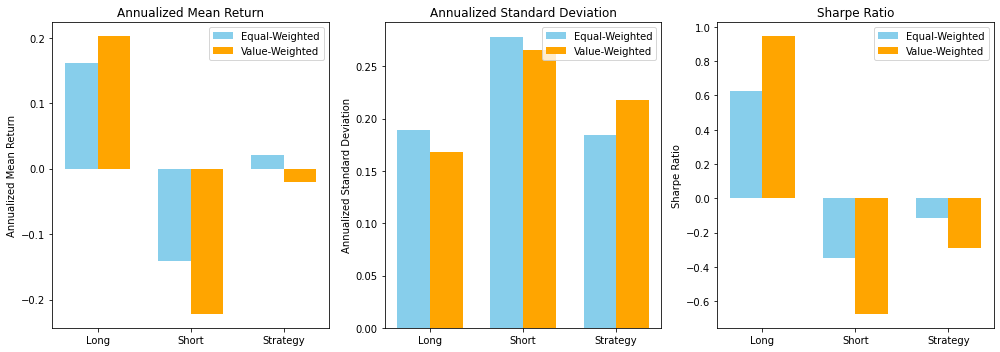

In [12]:
# Define the function to compute mean, standard deviation, and Sharpe ratio
def compute_metrics_momentum_strategy(momentum_data, rf):
    momentum_data = momentum_data.merge(rf, on='date')
    momentum_data['excess_return'] = momentum_data['ret'] - momentum_data['rf']
    annualized_mean_return = momentum_data['ret'].mean() * 12
    annualized_mean_excess_return = momentum_data['excess_return'].mean() * 12
    annualized_std = momentum_data['ret'].std() * np.sqrt(12)
    sharpe_ratio = annualized_mean_excess_return / annualized_std
    return annualized_mean_return, annualized_std, sharpe_ratio

# Function to test if the strategy return is significantly different from zero
def t_test_momentum_strategy_return(momentum_strategy_returns):
    t_stat_momentum, p_value_momentum = stats.ttest_1samp(momentum_strategy_returns, 0)
    return t_stat_momentum, p_value_momentum

# Compute the long-short portfolio returns
def long_short_momentum_returns(momentum_data):
    long_momentum_portfolio = momentum_data[momentum_data['Momentum_Q'].isin([7, 8, 9])]
    short_momentum_portfolio = momentum_data[momentum_data['Momentum_Q'].isin([0, 1, 2])]
    
    long_momentum_returns = long_momentum_portfolio.groupby('date')['ret'].mean().reset_index()
    short_momentum_returns = short_momentum_portfolio.groupby('date')['ret'].mean().reset_index()
    
    # Propagate Momentum_Q for proper grouping later
    long_momentum_returns['Momentum_Q'] = 1
    short_momentum_returns['Momentum_Q'] = 0
    
    momentum_strategy_returns = long_momentum_returns.copy()
    momentum_strategy_returns['ret'] = long_momentum_returns['ret'] - short_momentum_returns['ret']
    momentum_strategy_returns['Momentum_Q'] = 2
    
    return long_momentum_returns, short_momentum_returns, momentum_strategy_returns

# Compute metrics for equal-weighted portfolios
long_momentum_returns_ew, short_momentum_returns_ew, momentum_strategy_returns_ew = long_short_momentum_returns(ret_momentum_ew)
annualized_mean_momentum_return_ew, annualized_momentum_std_ew, sharpe_ratio_momentum_ew = compute_metrics_momentum_strategy(momentum_strategy_returns_ew, rf_data)
t_stat_momentum_ew, p_value_momentum_ew = t_test_momentum_strategy_return(momentum_strategy_returns_ew['ret'])

# Compute metrics for value-weighted portfolios
long_momentum_returns_vw, short_momentum_returns_vw, momentum_strategy_returns_vw = long_short_momentum_returns(ret_momentum_vw)
annualized_mean_momentum_return_vw, annualized_momentum_std_vw, sharpe_ratio_momentum_vw = compute_metrics_momentum_strategy(momentum_strategy_returns_vw, rf_data)
t_stat_momentum_vw, p_value_momentum_vw = t_test_momentum_strategy_return(momentum_strategy_returns_vw['ret'])

# Plot the results
labels = ['Long', 'Short', 'Strategy']
bar_width = 0.35
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(14, 5))

# Plot the annualized mean returns
plt.subplot(1, 3, 1)
plt.bar(r1, [mean_long_equal_momentum, -mean_short_equal_momentum, annualized_mean_momentum_return_ew], bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(r2, [mean_long_value_momentum, -mean_short_value_momentum, annualized_mean_momentum_return_vw], bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Mean Return')
plt.ylabel('Annualized Mean Return')
plt.xticks([r + bar_width/2 for r in r1], labels)
plt.legend()

# Plot the annualized standard deviation
plt.subplot(1, 3, 2)
plt.bar(r1, [std_long_equal_momentum, std_short_equal_momentum, annualized_momentum_std_ew], bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(r2, [std_long_value_momentum, std_short_value_momentum, annualized_momentum_std_vw], bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Standard Deviation')
plt.ylabel('Annualized Standard Deviation')
plt.xticks([r + bar_width/2 for r in r1], labels)
plt.legend()

# Plot the Sharpe ratios
plt.subplot(1, 3, 3)
plt.bar(r1, [sharpe_long_equal_momentum, -sharpe_short_equal_momentum, sharpe_ratio_momentum_ew], bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(r2, [sharpe_long_value_momentum, -sharpe_short_value_momentum, sharpe_ratio_momentum_vw], bar_width, label='Value-Weighted', color='orange')
plt.title('Sharpe Ratio')
plt.ylabel('Sharpe Ratio')
plt.xticks([r + bar_width/2 for r in r1], labels)
plt.legend()

plt.tight_layout()
plt.show()

Let's test if the strategy has an average return that is statistically significantly different from zero. It is a fundamental step in assessing the strategy's viability, reliability, and overall effectiveness in generating returns.

In [13]:
# Print t-test results
print(f"Equal-Weighted Strategy: t-stat = {t_stat_equal_momentum:.2f}, which has p-value = {p_value_equal_momentum:.2f}")
print(f"Value-Weighted Strategy: t-stat = {t_stat_value_momentum:.2f}, which has p-value = {p_value_value_momentum:.2f}")

Equal-Weighted Strategy: t-stat = 0.89, which has p-value = 0.37
Value-Weighted Strategy: t-stat = -0.69, which has p-value = 0.49


Statistical significance tests indicate that average strategy returns are not significantly different from zero, calling into question the effectiveness of the momentum strategies used in this analysis.

# 4. Idiosyncratic Volatility Strategy (IV)

Now, the goal is to determine the effectiveness and validity of the idiosyncratic volatility strategy which evaluates the performance of portfolios according to their idiosyncratic volatility. To do this, we must first calculate a temporal estimate of the idiosyncratic volatility for each stock.

In [ ]:
# Copy the original data to avoid modifying it
volatility_data = res.copy()

# Initialize an empty dictionary to store idiosyncratic volatilities for each stock
idiovols = {}

# Group the data by 'permno' (unique stock identifier)
for permno, grp in volatility_data.groupby('permno'):
    # Set the index to 'date' and create a rolling window of 60 periods with a minimum of 36 periods
    rolling = grp.set_index('date')[['excess_ret','excess_mkt_ret']].rolling(60, min_periods=36)
    
    curr = {}
    
    # Iterate over each rolling window
    for window in rolling:
        X = sm.add_constant(window['excess_mkt_ret'])
        y = window['excess_ret']
        
        # Fit the OLS regression model
        model = sm.OLS(y, X).fit()
        pred = model.predict(X)
        
        # Calculate the idiosyncratic volatility as the standard deviation of the residuals, annualized
        idio_vol = (y - pred).std() * np.sqrt(12)
        date = window.iloc[-1].name
        
        # Store the idiosyncratic volatility in the current dictionary with the date as the key
        curr[date] = idio_vol
    
    # After processing all windows for the current stock, store the results in the main dictionary
    idiovols[permno] = curr

# Convert the dictionary of idiosyncratic volatilities to a DataFrame
idio_df = pd.DataFrame(idiovols).T.stack().reset_index()

# Rename the columns to 'permno', 'date', and 'idio_vol'
idio_df.columns = ['permno', 'date', 'idio_vol']

# Save the DataFrame to a CSV file
idio_df.to_csv('idio_risk_df.csv', index=False)

In [15]:
# Load the CSV file into a DataFrame
volatility_data = pd.read_csv('idio_risk_df.csv')

# Display the DataFrame
display(volatility_data.head())

,date,permno,ret,vol,shrout,prc,mkt_cap,mkt_ret,rf,excess_ret,excess_mkt_ret,idio_vol,idio_Q,vw_Q,idio_ret_vw
0,2010-05-28,10001,0.004829,3451.0,6071.0,11.4000,69209.4000,-0.079240,0.000114,0.004715,-0.079354,5.523944e-17,0,0.000024,1.179439e-07
1,2010-04-30,10001,0.124385,3350.0,6070.0,11.3900,69137.3000,0.020036,0.000118,0.124267,0.019918,1.602407e-01,1,0.000037,4.558937e-06
2,2010-03-31,10001,0.020643,2283.0,4361.0,10.1700,44351.3700,0.063668,0.000112,0.020531,0.063556,2.125114e-01,3,0.000053,1.090644e-06
3,2010-02-26,10001,-0.000656,1510.0,4361.0,10.0084,43646.6324,0.034744,0.000061,-0.000717,0.034683,1.990379e-01,2,0.000039,-2.560898e-08
4,2010-01-29,10001,-0.018932,3104.0,4361.0,10.0600,43871.6600,-0.037172,0.000013,-0.018945,-0.037185,1.815296e-01,2,0.000039,-7.446845e-07


Let's analyze the performance of portfolios ranked by deciles based on their idiosyncratic volatility. By evaluating the average returns, volatility, and Sharpe ratios for the equal-weighted and value-weighted portfolios, we will test whether the results are consistent with the predictions of the CAPM model.

In [16]:
# Drop rows with missing values in the 'idio_vol' column
volatility_data = volatility_data.dropna(subset=['idio_vol']).copy()

# Create a new column 'idio_Q' that represents decile rankings of idiosyncratic volatility within each date
volatility_data['idio_Q'] = volatility_data.groupby('date')['idio_vol'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Calculate the value weights for each momentum decile within each date
volatility_data['vw_Q'] = volatility_data['mkt_cap'] / volatility_data.groupby(['date', 'idio_Q'])['mkt_cap'].transform('sum')

# Calculate value-weighted returns for each idiosyncratic volatility decile
volatility_data['idio_ret_vw'] = volatility_data['vw_Q'] * volatility_data['ret']
ret_idio_vw = volatility_data.groupby(['date', 'idio_Q'])['idio_ret_vw'].sum().reset_index()
ret_idio_mean_vw = ret_idio_vw.groupby('idio_Q')['idio_ret_vw'].mean()

# Rename the 'idio_ret_vw' column to 'ret' for value-weighted returns
ret_idio_vw = ret_idio_vw.rename(columns={"idio_ret_vw": "ret"})

# Calculate the equal-weighted mean return for each idiosyncratic volatility decile
ret_idio_ew = volatility_data.groupby(['date', 'idio_Q'])['ret'].mean().reset_index()
ret_idio_mea_ewn = ret_idio_ew.groupby('idio_Q')['ret'].mean()

Here are the plots of the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots.

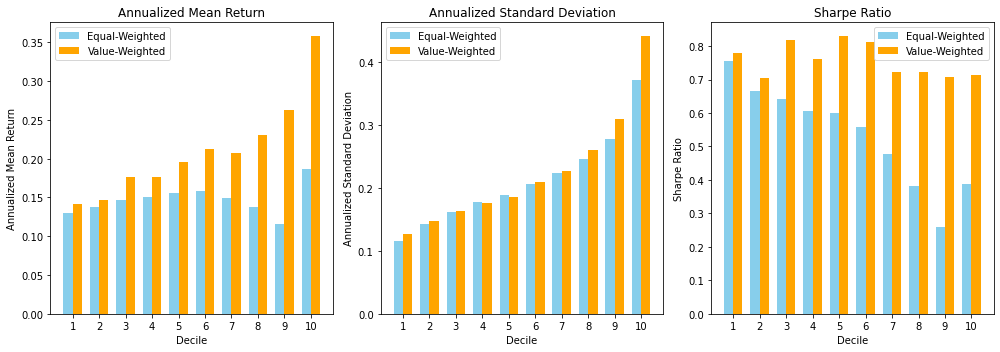

In [17]:
# Function to compute annualized returns, standard deviation, and Sharpe ratio
def compute_metrics_volatility(volatility_data, rf):
    # Ensure 'date' column in both DataFrames is in datetime format
    volatility_data['date'] = pd.to_datetime(volatility_data['date'])
    rf['date'] = pd.to_datetime(rf['date'])
    
    volatility_data = volatility_data.merge(rf, on='date')
    volatility_data['excess_return'] = volatility_data['ret'] - volatility_data['rf']
    annualized_mean_return = volatility_data.groupby('idio_Q')['ret'].mean() * 12
    annualized_mean_excess_return = volatility_data.groupby('idio_Q')['excess_return'].mean() * 12
    annualized_std = volatility_data.groupby('idio_Q')['ret'].std() * (12 ** 0.5)
    sharpe_ratio = annualized_mean_excess_return / annualized_std
    return annualized_mean_return, annualized_std, sharpe_ratio

# Computing metrics for both VW and EW
annualized_mean_return_vw_volatility, annualized_std_vw_volatility, sharpe_ratio_vw_volatility = compute_metrics_volatility(ret_idio_vw, rf_data)
annualized_mean_return_ew_volatility, annualized_std_ew_volatility, sharpe_ratio_ew_volatility = compute_metrics_volatility(ret_idio_ew, rf_data)

# Plot the metrics side by side
deciles = np.arange(1, 11)
bar_width = 0.35

plt.figure(figsize=(14, 5))

# Plot the annualized mean returns
plt.subplot(1, 3, 1)
plt.bar(deciles - bar_width/2, annualized_mean_return_ew_volatility, bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, annualized_mean_return_vw_volatility, bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Mean Return')
plt.xlabel('Decile')
plt.ylabel('Annualized Mean Return')
plt.xticks(deciles)
plt.legend()

# Plot the annualized standard deviation
plt.subplot(1, 3, 2)
plt.bar(deciles - bar_width/2, annualized_std_ew_volatility, bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, annualized_std_vw_volatility, bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Standard Deviation')
plt.xlabel('Decile')
plt.ylabel('Annualized Standard Deviation')
plt.xticks(deciles)
plt.legend()

# Plot the Sharpe ratios
plt.subplot(1, 3, 3)
plt.bar(deciles - bar_width/2, sharpe_ratio_ew_volatility, bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(deciles + bar_width/2, sharpe_ratio_vw_volatility, bar_width, label='Value-Weighted', color='orange')
plt.title('Sharpe Ratio')
plt.xlabel('Decile')
plt.ylabel('Sharpe Ratio')
plt.xticks(deciles)
plt.legend()

plt.tight_layout()
plt.show()

Summarize our findings : 
- **Annualized Mean Return** : Returns increase across deciles for both equal-weighted and value-weighted portfolios, with the highest returns in the top deciles, particularly for value-weighted portfolios. This contradicts the CAPM, which suggests returns should depend only on systematic risk (beta), not idiosyncratic volatility.

- **Annualized Standard Deviation** : Volatility increases across deciles, with higher deciles showing greater total volatility. The CAPM implies that only systematic risk should be priced, but the positive correlation between idiosyncratic volatility and total volatility challenges this view, suggesting investors might price idiosyncratic risk.

- **Sharpe Ratio** : Sharpe ratios improve across deciles, especially for value-weighted portfolios. This indicates that portfolios with higher idiosyncratic volatility provide better risk-adjusted returns. According to the CAPM, higher Sharpe ratios should be associated with higher beta, not idiosyncratic volatility. The improvement in Sharpe ratios with higher idiosyncratic volatility suggests that idiosyncratic risk contributes to returns in a way not explained by the CAPM.

Finally, we can develop a trading strategy using the idiosyncratic volatility factor. By comparing the performance of long and short portfolios as well as the overall strategy, we will test the effectiveness of this approach and its alignment with existing results in the study of Ang, Hodrick, Xing, and Zhang (2006).

In [18]:
# Calculate monthly returns for long and short legs (equal-weighted)
long_deciles = [7, 8, 9]
short_deciles = [0, 1, 2]

# Calculate returns for long and short legs (equal-weighted)
long_equal_returns_volatility = ret_idio_ew[ret_idio_ew['idio_Q'].isin(long_deciles)].groupby('date')['ret'].mean()
short_equal_returns_volatility = ret_idio_ew[ret_idio_ew['idio_Q'].isin(short_deciles)].groupby('date')['ret'].mean()
volatility_equal_returns = long_equal_returns_volatility - short_equal_returns_volatility

# Calculate returns for long and short legs (value-weighted)
long_value_returns_volatility = ret_idio_vw[ret_idio_vw['idio_Q'].isin(long_deciles)].groupby('date')['ret'].mean()
short_value_returns_volatility = ret_idio_vw[ret_idio_vw['idio_Q'].isin(short_deciles)].groupby('date')['ret'].mean()
volatility_value_returns = long_value_returns_volatility - short_value_returns_volatility

# Function to calculate financial metrics
def compute_financial_metrics_momentum(volatility_data, rf):
    volatility_data = volatility_data.reset_index()
    volatility_data = volatility_data.merge(rf, on='date')
    volatility_data['excess_return'] = volatility_data['ret'] - volatility_data['rf']
    annualized_mean_return = volatility_data['ret'].mean() * 12
    annualized_mean_excess_return = volatility_data['excess_return'].mean() * 12
    annualized_std = volatility_data['ret'].std() * np.sqrt(12)
    sharpe_ratio = annualized_mean_excess_return / annualized_std
    return annualized_mean_return, annualized_std, sharpe_ratio

# Calculate metrics for equal-weighted returns
mean_long_equal_volatility, std_long_equal_volatility, sharpe_long_equal_volatility = compute_financial_metrics_momentum(long_equal_returns_volatility, rf_data)
mean_short_equal_volatility, std_short_equal_volatility, sharpe_short_equal_volatility = compute_financial_metrics_momentum(short_equal_returns_volatility, rf_data)
mean_volatility_equal, std_volatility_equal, sharpe_volatility_equal = compute_financial_metrics_momentum(volatility_equal_returns, rf_data)

# Calculate metrics for value-weighted returns
mean_long_value_volatility, std_long_value_volatility, sharpe_long_value_volatility = compute_financial_metrics_momentum(long_value_returns_volatility, rf_data)
mean_short_value_volatility, std_short_value_volatility, sharpe_short_value_volatility = compute_financial_metrics_momentum(short_value_returns_volatility, rf_data)
mean_volatility_value, std_volatility_value, sharpe_volatility_value = compute_financial_metrics_momentum(volatility_value_returns, rf_data)

# Test if the average return of the strategy is significantly different from zero
t_stat_equal_volatility, p_value_equal_volatility = stats.ttest_1samp(volatility_equal_returns, 0)
t_stat_value_volatility, p_value_value_volatility = stats.ttest_1samp(volatility_value_returns, 0)

# Display results side by side
volatility_equal_weighted_portfolios = f"""
<div style="display: inline-block; width: 45%; vertical-align: top;">
    <h3>Equal-Weighted Portfolios:</h3>
    <p>Mean Long Return: {mean_long_equal_volatility:.4f}</p>
    <p>Std Dev Long Return: {std_long_equal_volatility:.4f}</p>
    <p>Sharpe Ratio Long: {sharpe_long_equal_volatility:.4f}</p>
    <p>Mean Short Return: {mean_short_equal_volatility:.4f}</p>
    <p>Std Dev Short Return: {std_short_equal_volatility:.4f}</p>
    <p>Sharpe Ratio Short: {sharpe_short_equal_volatility:.4f}</p>
    <p>Mean Idiosyncratic Vol Return: {mean_volatility_equal:.4f}</p>
    <p>Std Dev Idiosyncratic Vol Return: {std_volatility_equal:.4f}</p>
    <p>Sharpe Ratio Idiosyncratic Vol: {sharpe_volatility_equal:.4f}</p>
    <p>t-Statistic Idiosyncratic Vol: {t_stat_equal_volatility:.4f}</p>
    <p>p-Value Idiosyncratic Vol: {p_value_equal_volatility:.4f}</p>
</div>
"""

volatility_value_weighted_portfolios = f"""
<div style="display: inline-block; width: 45%; vertical-align: top;">
    <h3>Value-Weighted Portfolios:</h3>
    <p>Mean Long Return: {mean_long_value_volatility:.4f}</p>
    <p>Std Dev Long Return: {std_long_value_volatility:.4f}</p>
    <p>Sharpe Ratio Long: {sharpe_long_value_volatility:.4f}</p>
    <p>Mean Short Return: {mean_short_value_volatility:.4f}</p>
    <p>Std Dev Short Return: {std_short_value_volatility:.4f}</p>
    <p>Sharpe Ratio Short: {sharpe_short_value_volatility:.4f}</p>
    <p>Mean Idiosyncratic Vol Return: {mean_volatility_value:.4f}</p>
    <p>Std Dev Idiosyncratic Vol Return: {std_volatility_value:.4f}</p>
    <p>Sharpe Ratio Idiosyncratic Vol: {sharpe_volatility_value:.4f}</p>
    <p>t-Statistic Idiosyncratic Vol: {t_stat_value_volatility:.4f}</p>
    <p>p-Value Idiosyncratic Vol: {p_value_value_volatility:.4f}</p>
</div>
"""

display(HTML(volatility_equal_weighted_portfolios + volatility_value_weighted_portfolios))

Display what we got in a graph will help us better understand the results.

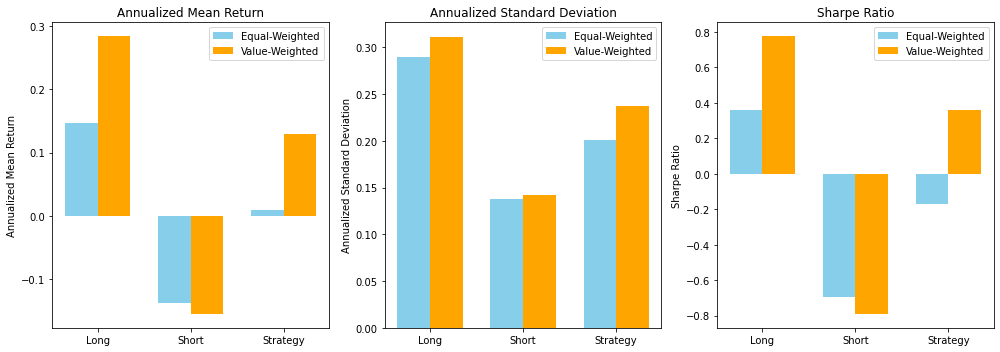

In [19]:
# Define the function to compute mean, standard deviation, and Sharpe ratio
def compute_metrics_volatility_strategy(volatility_data, rf):
    volatility_data = volatility_data.merge(rf, on='date')
    volatility_data['excess_return'] = volatility_data['ret'] - volatility_data['rf']
    annualized_mean_return = volatility_data['ret'].mean() * 12
    annualized_mean_excess_return = volatility_data['excess_return'].mean() * 12
    annualized_std = volatility_data['ret'].std() * np.sqrt(12)
    sharpe_ratio = annualized_mean_excess_return / annualized_std
    return annualized_mean_return, annualized_std, sharpe_ratio

# Function to test if the strategy return is significantly different from zero
def t_test_volatility_strategy_return(volatility_strategy_returns):
    t_stat_volatility, p_value_volatility = stats.ttest_1samp(volatility_strategy_returns, 0)
    return t_stat_volatility, p_value_volatility

# Compute the long-short portfolio returns
def long_short_volatility_returns(volatility_data):
    long_volatility_portfolio = volatility_data[volatility_data['idio_Q'].isin([7, 8, 9])]
    short_volatility_portfolio = volatility_data[volatility_data['idio_Q'].isin([0, 1, 2])]
    
    long_volatility_returns = long_volatility_portfolio.groupby('date')['ret'].mean().reset_index()
    short_volatility_returns = short_volatility_portfolio.groupby('date')['ret'].mean().reset_index()
    
    # Propagate idio_Q for proper grouping later
    long_volatility_returns['idio_Q'] = 1
    short_volatility_returns['idio_Q'] = 0
    
    volatility_strategy_returns = long_volatility_returns.copy()
    volatility_strategy_returns['ret'] = long_volatility_returns['ret'] - short_volatility_returns['ret']
    volatility_strategy_returns['idio_Q'] = 2
    
    return long_volatility_returns, short_volatility_returns, volatility_strategy_returns

# Compute metrics for equal-weighted portfolios
long_volatility_returns_ew, short_volatility_returns_ew, volatility_strategy_returns_ew = long_short_volatility_returns(ret_idio_ew)
annualized_mean_volatility_return_ew, annualized_volatility_std_ew, sharpe_ratio_volatility_ew = compute_metrics_volatility_strategy(volatility_strategy_returns_ew, rf_data)
t_stat_volatility_ew, p_value_volatility_ew = t_test_volatility_strategy_return(volatility_strategy_returns_ew['ret'])

# Compute metrics for value-weighted portfolios
long_volatility_returns_vw, short_volatility_returns_vw, volatility_strategy_returns_vw = long_short_volatility_returns(ret_idio_vw)
annualized_mean_volatility_return_vw, annualized_volatility_std_vw, sharpe_ratio_volatility_vw = compute_metrics_volatility_strategy(volatility_strategy_returns_vw, rf_data)
t_stat_volatility_vw, p_value_volatility_vw = t_test_volatility_strategy_return(volatility_strategy_returns_vw['ret'])

# Plot the results
labels = ['Long', 'Short', 'Strategy']
bar_width = 0.35
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(14, 5))

# Plot the annualized mean returns
plt.subplot(1, 3, 1)
plt.bar(r1, [mean_long_equal_volatility, -mean_short_equal_volatility, annualized_mean_volatility_return_ew], bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(r2, [mean_long_value_volatility, -mean_short_value_volatility, annualized_mean_volatility_return_vw], bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Mean Return')
plt.ylabel('Annualized Mean Return')
plt.xticks([r + bar_width/2 for r in r1], labels)
plt.legend()

# Plot the annualized standard deviation
plt.subplot(1, 3, 2)
plt.bar(r1, [std_long_equal_volatility, std_short_equal_volatility, annualized_volatility_std_ew], bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(r2, [std_long_value_volatility, std_short_value_volatility, annualized_volatility_std_vw], bar_width, label='Value-Weighted', color='orange')
plt.title('Annualized Standard Deviation')
plt.ylabel('Annualized Standard Deviation')
plt.xticks([r + bar_width/2 for r in r1], labels)
plt.legend()

# Plot the Sharpe ratios
plt.subplot(1, 3, 3)
plt.bar(r1, [sharpe_long_equal_volatility, -sharpe_short_equal_volatility, sharpe_ratio_volatility_ew], bar_width, label='Equal-Weighted', color='skyblue')
plt.bar(r2, [sharpe_long_value_volatility, -sharpe_short_value_volatility, sharpe_ratio_volatility_vw], bar_width, label='Value-Weighted', color='orange')
plt.title('Sharpe Ratio')
plt.ylabel('Sharpe Ratio')
plt.xticks([r + bar_width/2 for r in r1], labels)
plt.legend()

plt.tight_layout()
plt.show()

The idiosyncratic volatility strategy appears profitable for value-weighted portfolios, but not for equal-weighted portfolios, calling into question the CAPM predictions. But let's check if, statistically, this is confirmed by testing.

In [20]:
# Print t-test results
print(f"Equal-Weighted Strategy: t-stat = {t_stat_equal_volatility:.2f}, which has p-value = {p_value_equal_volatility:.2f}")
print(f"Value-Weighted Strategy: t-stat = {t_stat_value_volatility:.2f}, which has p-value = {p_value_value_volatility:.2f}")

Equal-Weighted Strategy: t-stat = 0.33, which has p-value = 0.74
Value-Weighted Strategy: t-stat = 4.20, which has p-value = 0.00


Value-weighted portfolios exhibit significantly higher annualized average returns and Sharpe ratios than equally weighted portfolios, indicating that the idiosyncratic volatility strategy is particularly effective for large-cap stocks.

# 5. Optimal Fund Portfolio Return (STRAT)

The objective of question is to construct an optimal portfolio by combining three investment strategies: Betting against Beta (BaB), Idiosyncratic Volatility (IV) and Momentum (MoM), and to evaluate the portfolio's performance. This code prepares the data needed for this analysis by creating a unified DataFrame containing the returns from the different strategies.

In [26]:
# Copy and rename columns of the DataFrame for the equal-weighted idiosyncratic volatility strategy
strat_idio_ew = volatility_strategy_returns_ew.copy()
strat_idio_ew = strat_idio_ew.rename(columns={"ret": "idio_ret_ew"})

# Copy and rename columns of the DataFrame for the value-weighted idiosyncratic volatility strategy
strat_idio_vw = volatility_strategy_returns_vw.copy()
strat_idio_vw = strat_idio_vw.rename(columns={"ret": "idio_ret_vw"})

# Copy and rename columns of the DataFrame for the equal-weighted momentum strategy
strat_momentum_ew = momentum_strategy_returns_ew.copy()
strat_momentum_ew = strat_momentum_ew.rename(columns={"ret": "momentum_ret_ew"})

# Copy and rename columns of the DataFrame for the value-weighted momentum strategy
strat_momentum_vw = momentum_strategy_returns_vw.copy()
strat_momentum_vw = strat_momentum_vw.rename(columns={"ret": "momentum_ret_vw"})

# Merge all strategies on the 'date' column
strat = pd.merge(strat_idio_ew, strat_idio_vw, on='date', how='inner')
strat = pd.merge(strat, strat_momentum_ew, on='date', how='inner')
strat = pd.merge(strat, strat_momentum_vw, on='date', how='inner')
strat = pd.merge(strat, BAB[['date', 'BAB']], on='date', how='inner')

# Keep only the columns: 'date', 'idio_ret_vw', 'momentum_ret_vw', 'BAB'
strat = strat[['date', 'idio_ret_vw', 'momentum_ret_vw', 'BAB']]

# Merge with the risk-free rate data
strat = pd.merge(strat, rf_data, on='date', how='inner')

# Display the final DataFrame
display(strat.head())

,date,idio_ret_vw,momentum_ret_vw,BAB,rf
0,1967-02-28,0.093200,0.021865,0.017425,0.003737
1,1967-06-30,0.161322,0.067142,-0.008898,0.003089
2,1967-08-31,0.033255,-0.007620,0.015317,0.003216
3,1967-11-30,0.026178,0.014570,0.004147,0.003491
4,1968-02-29,-0.050906,-0.057446,-0.019772,0.003894


Now, we have to extract returns from value-weighted strategies, calculates excess returns, and determines averages, volatilities, and covariance matrices over a rolling 12-month window for analyzing strategy performance.

In [27]:
# Extract value-weighted strategy returns
strategies_vw = strat[['BAB', 'idio_ret_vw', 'momentum_ret_vw']]
strategies_vw.columns = ['BaB', 'IV', 'MoM']

# Calculate excess returns
rf_monthly = strat['rf']
excess_returns_vw = strategies_vw.sub(rf_monthly, axis=0)

# Set the rolling window size to 12 months (1 year)
window = 12

# Calculate rolling window volatilities (annualized)
volatility_vw = strategies_vw.rolling(window=window).std() * np.sqrt(12)

# Calculate rolling window mean return (annualized)
mean_returns_vw = strategies_vw.rolling(window=window).mean() * 12

# Calculate rolling window excess mean returns
mean_excess_returns_vw = excess_returns_vw.rolling(window=window).mean()

# Calculate rolling window covariance matrices
cov_matrices_vw = strategies_vw.rolling(window=window).cov(pairwise=True)

# Calculate mean and standard deviation of strategy returns
mean_std_vw = excess_returns_vw.agg(['mean', 'std'])

Let's calculate the performance of an equally weighted strategy by combining the returns of the BaB, IV and MoM strategies. 

In [29]:
## Equal Weight ##
# Define equal weights for the strategies
equal_weights = np.array([1/3, 1/3, 1/3])

# Compute weighted returns
equal_weighted_ret_vw = strategies_vw.dot(equal_weights)

# Compute the weighted excess returns
excess_rt_equal_vw = excess_returns_vw.dot(equal_weights)

# Calculate the mean of the returns (annualized)
mean_ret_equal_vw = equal_weighted_ret_vw.mean() * 12

# Calculate the mean of the excess returns (annualized)
mean_excess_rt_equal_vw = excess_rt_equal_vw.mean() * 12

# Calculate the standard deviation of the excess returns (annualized)
std_rt_equal_vw = equal_weighted_ret_vw.std() * np.sqrt(12)

# Calculate the Sharpe ratio
sharpe_ratio_equal_vw = mean_excess_rt_equal_vw / std_rt_equal_vw

# Print the results
print('Equal Weighted Strategy:')
print(f'- Mean Return: {mean_ret_equal_vw:.4f}')
print(f'- Mean Excess Return: {mean_excess_rt_equal_vw:.4f}')
print(f'- Standard Deviation: {std_rt_equal_vw:.4f}')
print(f'- Sharpe Ratio: {sharpe_ratio_equal_vw:.4f}')

Equal Weighted Strategy:
- Mean Return: 0.0766
- Mean Excess Return: 0.0343
- Standard Deviation: 0.0860
- Sharpe Ratio: 0.3984


Let's calculate the performance of a risk parity strategy by combining the returns of BaB, IV and MoM strategies, based on the rolling window estimate of the strategy returns means and covariancies that we computed before.

In [30]:
# Calculate inverse volatilities for each strategy
inv_volatility_vw = 1 / volatility_vw

# Calculate weights for risk parity strategy by normalizing inverse volatilities
weights_rp_vw = inv_volatility_vw.div(inv_volatility_vw.sum(axis=1), axis=0)

# Replace NaN values with equal weights (1/3)
weights_rp_vw = weights_rp_vw.fillna(1/3)

# Compute the risk parity portfolio returns
rst_rp_vw = (strategies_vw * weights_rp_vw).sum(axis=1)

# Compute the excess returns of the risk parity portfolio
excess_ret_rp_vw = rst_rp_vw - rf_monthly

# Calculate the mean return of the risk parity portfolio (annualized)
mean_ret_rp_vw = rst_rp_vw.mean() * 12

# Calculate the mean excess return of the risk parity portfolio (annualized)
mean_excess_ret_rp_vw = excess_ret_rp_vw.mean() * 12

# Calculate the standard deviation of the risk parity portfolio (annualized)
std_ret_rp_vw = rst_rp_vw.std() * np.sqrt(12)

# Calculate the Sharpe ratio of the risk parity portfolio
sharpe_ratio_rp_vw = mean_excess_ret_rp_vw / std_ret_rp_vw

# Print the results
print('Risk Parity Strategy:')
print(f'- Mean Return: {mean_ret_rp_vw:.4f}')
print(f'- Mean Excess Return: {mean_excess_ret_rp_vw:.4f}')
print(f'- Standard Deviation: {std_ret_rp_vw:.4f}')
print(f'- Sharpe Ratio: {sharpe_ratio_rp_vw:.4f}')

Risk Parity Strategy:
- Mean Return: 0.0791
- Mean Excess Return: 0.0368
- Standard Deviation: 0.0835
- Sharpe Ratio: 0.4403


This code calculates the performance of an optimal mean-variance combination strategy using the average returns and covariance matrices of the BaB, IV and MoM strategies over a sliding window and with risk assumption assumed to be 1.

In [33]:
# Define the mean-variance utility function
def negative_mean_variance_utility(weights, mean_ret, cov_matrix):
    port_return = np.dot(weights, mean_ret) * 12  # Annualize the portfolio return
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))  # Annualize the portfolio volatility
    utility = port_return - 1/2 * (port_volatility ** 2)
    return -utility

# List to store the optimal weights for each rolling window
weights_mvo_vw = []

# Loop through each rolling window
for i in range(window, len(strategies_vw)):
    mean_ret = mean_returns_vw.iloc[i].values  # Mean returns for the current window
    cov_matrix = cov_matrices_vw.iloc[i * 3:(i + 1) * 3].values.reshape(3, 3)  # Covariance matrix for the current window
    
    # Optimize the weights using the mean-variance utility function
    result = minimize(negative_mean_variance_utility, [1/3, 1/3, 1/3], args=(mean_ret, cov_matrix),
                      method='SLSQP', bounds=[(0, 1)] * 3, constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    weights_mvo_vw.append(result.x) 

# Convert the list of optimal weights to a DataFrame
weights_mvo_vw = pd.DataFrame(weights_mvo_vw, index=strategies_vw.index[window:], columns=['BaB', 'IV', 'MoM'])

# Calculate the returns of the mean-variance optimized portfolio
rst_mvo_vw = (strategies_vw[window:] * weights_mvo_vw).sum(axis=1)

# Calculate the excess returns
excess_ret_mvo_vw = rst_mvo_vw - rf_monthly[window:]

# Calculate the standard deviation of the excess returns (annualized)
std_mvo_vw = excess_ret_mvo_vw.std() * np.sqrt(12)

# Calculate the mean return (annualized)
mean_ret_mvo_vw = rst_mvo_vw.mean() * 12

# Calculate the Sharpe ratio
sharpe_ratio_mvo_vw = excess_ret_mvo_vw.mean() / std_mvo_vw

# Print the results
print('Mean-Variance Optimization Strategy:')
print(f'- Mean Return: {mean_ret_mvo_vw:.4f}')
print(f'- Standard Deviation: {std_mvo_vw:.4f}')
print(f'- Sharpe Ratio: {sharpe_ratio_mvo_vw:.4f}')

Mean-Variance Optimization Strategy:
- Mean Return: 0.2781
- Standard Deviation: 0.2506
- Sharpe Ratio: 0.0786


This code adjusts portfolio returns to achieve a target volatility of 10%, then calculates performance metrics (average return, volatility, and Sharpe ratio) for equally weighted, risk parity, and mean-variance optimization strategies.

In [34]:
# Define the target volatility
target_volatility = 0.10

# Function to adjust the portfolio returns to the target volatility
def adjust_volatility(rst, target_vol):
    scaling_factor = target_vol / (rst.std() * np.sqrt(12))
    return scaling_factor * rst

# Adjust the returns for each strategy to the target volatility
rst_equal_adj_vw = adjust_volatility(equal_weighted_ret_vw, target_volatility)
rst_rp_adj_vw = adjust_volatility(rst_rp_vw, target_volatility)
rst_mvo_adj_vw = adjust_volatility(rst_mvo_vw, target_volatility)

# Compute excess returns by subtracting the risk-free rate
rst_equal_adj_excess_vw = rst_equal_adj_vw - rf_monthly
rst_rp_adj_excess_vw = rst_rp_adj_vw - rf_monthly
rst_mvo_adj_excess_vw = rst_mvo_adj_vw - rf_monthly[window:]

# Function to calculate performance metrics
def performance_metrics(rst_adj, rst_adj_excess):
    mean_return = rst_adj.mean() * 12
    volatility = rst_adj.std() * np.sqrt(12)
    mean_excess_return = rst_adj_excess.mean() * 12
    
    sharpe_ratio = mean_excess_return / volatility
    return mean_return, volatility, sharpe_ratio

# Calculate performance metrics for each adjusted strategy
perf_equal_vw = performance_metrics(rst_equal_adj_vw, rst_equal_adj_excess_vw)
perf_rp_vw = performance_metrics(rst_rp_adj_vw, rst_rp_adj_excess_vw)
perf_mvo_vw = performance_metrics(rst_mvo_adj_vw, rst_mvo_adj_excess_vw)

# Compile results into a dictionary
results_vw = {
    'Equal Weight VW': perf_equal_vw,
    'Risk Parity VW': perf_rp_vw,
    'Mean-Variance Optimization VW': perf_mvo_vw
}

# Convert the results dictionary into a DataFrame and set the index to the metrics
results_vw = pd.DataFrame(results_vw, index=['Mean Return', 'Volatility', 'Sharpe Ratio'])

# Display the results
display(pd.DataFrame(results_vw))

,Equal Weight VW,Risk Parity VW,Mean-Variance Optimization VW
Mean Return,0.089038,0.094666,0.111048
Volatility,0.100000,0.100000,0.100000
Sharpe Ratio,0.467324,0.523608,0.691607


The final results show the performance of different value-weighted investment strategies with a target volatility of 10%. These results show that the mean-variance optimization approach outperforms other strategies in terms of average risk-adjusted return. The risk parity strategy offers intermediate performance, while the equally weighted strategy, although simple to implement, performs the worst of the three in terms of risk-adjusted return.

# 6. Performance and Risk Analysis for the Fund Strategy

The objective of this part is to analyze the performance and risks of the fund's strategy by regressing the returns of the strategy on the sector portfolios and the Fama-French factors. First, we need to collect data from the 12 sector portfolios from Ken French's page and the 5 Fama-French research factors, then, merge this data with the strategy's returns.

In [86]:
# Load the industry returns data
industry_returns_file = '12_Industry_Portfolios.csv'  # Specify the file containing the industry returns data
Industry_Returns = pd.read_csv(industry_returns_file, skiprows=1)  # Read the CSV file, skipping the first row (header)

# Convert the date to datetime format
Industry_Returns['Unnamed: 0'] = pd.to_datetime(Industry_Returns['Unnamed: 0'], format='%Y%m')

# Keep only data between January 1964 to end of December 2023
Industry_Returns = Industry_Returns[(Industry_Returns['Unnamed: 0'] >= '1964-01-01') & (Industry_Returns['Unnamed: 0'] <= '2023-12-31')]

# Rename the date column for easier reference
Industry_Returns = Industry_Returns.rename(columns={'Unnamed: 0': 'date'})

# Display the first few rows of the industry returns data
Industry_Returns.head()

# Load the risk parity returns data
risk_parity_file = 'strategies_vw.csv' 
risk_parity_ew = pd.read_csv(risk_parity_file)
risk_parity_weights_vw['date'] = pd.to_datetime(risk_parity_weights_vw['date'])
risk_parity_ew = risk_parity_ew[['RiskParity', 'date']]

# Convert the date column to datetime format
risk_parity_ew['date'] = pd.to_datetime(risk_parity_ew['date'])

# Change the date format to save only the month and year for risk parity returns
risk_parity_ew['date'] = risk_parity_ew['date'].dt.to_period('M')

# Do the same for industry returns
Industry_Returns['date'] = Industry_Returns['date'].dt.to_period('M')

# Merge the risk parity returns data with the industry returns data on the 'date' column
tmp = pd.merge(risk_parity_ew, Industry_Returns, on='date', how='left')

# Add a constant column for the regression
tmp['const'] = 1

# Drop any rows with missing values
tmp = tmp.dropna()

# Display the merged DataFrame
tmp.head()

,RiskParity,date,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,const
0,0.031807,1964-04,-0.47,1.80,-1.79,4.04,-1.48,-3.79,0.83,1.05,2.88,-1.42,-1.02,1.10,1
1,0.003862,1964-08,-0.26,1.40,-0.85,-1.86,-2.09,-2.84,-1.56,-0.02,0.34,-4.22,-2.18,-3.65,1
2,0.026867,1964-09,1.69,4.64,4.87,3.08,4.55,1.11,-1.03,1.88,3.48,2.74,2.51,4.85,1
3,0.008181,1964-10,-0.19,0.08,0.17,3.07,0.95,-1.02,-0.89,0.96,2.31,2.86,-0.68,3.15,1
4,-0.003831,1964-11,0.71,-1.09,-1.55,2.54,1.50,-0.29,-2.22,1.37,3.24,2.17,-0.86,-2.09,1


We can now perform multiple regressions of the strategy returns on the sector portfolio returns and the Fama-French factors in order to analyze the coefficients (betas), t statistics and R² values ​​to assess the importance and adjustment of risk factors.

In [53]:
# List of industry names to be used in the regression
Industries = ['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth ', 'Money', 'Other']

# Perform the OLS regression of the Risk Parity strategy returns on the industry portfolio returns
# Add a constant to the independent variables (industry returns)
RegOLS = sm.OLS(tmp['RiskParity'], tmp[['const'] + Industries]).fit()

# Create a DataFrame to display the regression coefficients and their t-values with appropriate column names
results_df = pd.DataFrame({
    'Coefficient': RegOLS.params,
    'T-Value': RegOLS.tvalues
})

# Display the results
print(results_df)

# Print the R-squared value of the regression
print("R-squared:", RegOLS.rsquared)

       Coefficient   T-Value
const     0.005004  4.059447
NoDur     0.000978  1.593582
Durbl     0.000525  2.030433
Manuf    -0.000438 -0.572889
Enrgy    -0.000269 -1.118815
Chems    -0.000420 -0.689189
BusEq    -0.000649 -1.965320
Telcm    -0.000383 -0.899012
Utils     0.000404  1.034090
Shops    -0.000481 -0.971068
Hlth      0.000067  0.168132
Money     0.001227  2.461162
Other     0.001365  2.082079
R-squared: 0.2694375123638898


The factors “Durbl”, “Money” and “Other” are significant drivers of risk parity strategy returns, as indicated by their regression coefficients and values ​​of t significant. The model explains approximately 26.9% of the variance in strategy returns (R² = 0.269), suggesting that these factors partially contribute to strategy performance. Furthermore, the positive and significant alpha (0.005004) indicates that the strategy generates excess returns not explained by the sector risks included in the model.

Let's move on to linear regression which is responsible for evaluating the influence of the Fama-French factors on the strategy's returns.

In [66]:
# Load the Fama-French 5 Factors data
fama = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, sep=',')

# Convert the date column to datetime format
fama['Unnamed: 0'] = pd.to_datetime(fama['Unnamed: 0'], format='%Y%m')

# Rename the date column for easier reference
fama = fama.rename(columns={'Unnamed: 0': 'date'})

# Change datatime format
fama['date'] = fama['date'].dt.to_period('M')

# Merge the equal-weighted risk parity returns with the Fama-French factors on the date column
tmp1 = pd.merge(risk_parity_ew, fama[['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].drop_duplicates(), on='date', how='left')

# Add a constant for the intercept in the regression
tmp1['const'] = 1

# Drop rows with missing values
tmp1 = tmp1.dropna()

# Perform a linear regression using Fama-French factors as explanatory variables
RegOLS1 = sm.OLS(tmp1['RiskParity'], tmp1[['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]).fit()

# Display the regression coefficients and t-values
print(pd.concat([RegOLS1.params, RegOLS1.tvalues], axis=1))

# Display the R-squared value to evaluate the model's fit
print(RegOLS1.rsquared)

               0         1
const   0.003293  2.715598
Mkt-RF  0.001641  5.953235
SMB     0.002245  5.292106
HML     0.002087  3.638500
RMW     0.001582  3.186265
CMA    -0.000467 -0.579689
0.28478622855411373


The results show that the factors Mkt-RF, SMB, HML and RMW are significant, with respective t-values ​​of 5.953, 5.292, 3.639 and 3.186, indicating that they strongly influence the strategy's returns. On the other hand, the CMA factor is not significant with a t-value of -0.580. The R-squared of 0.285 indicates that the Fama-French factors explain approximately 28.48% of the variance in strategy returns, showing a partial but notable explanation of the strategy's performance.